# MoA Pytorch Neural Oblivious Decision Ensembles (NODE)

The NODE model is potential. Here, I post a custom architecture different from the original paper and get an baseline result. I don't find QHAdam (used in original paper) to be better than Adam.

**Version 1:** CV 0.01654, LB 0.01900

From paper [Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data][1]. 

Github: https://github.com/Qwicen/node

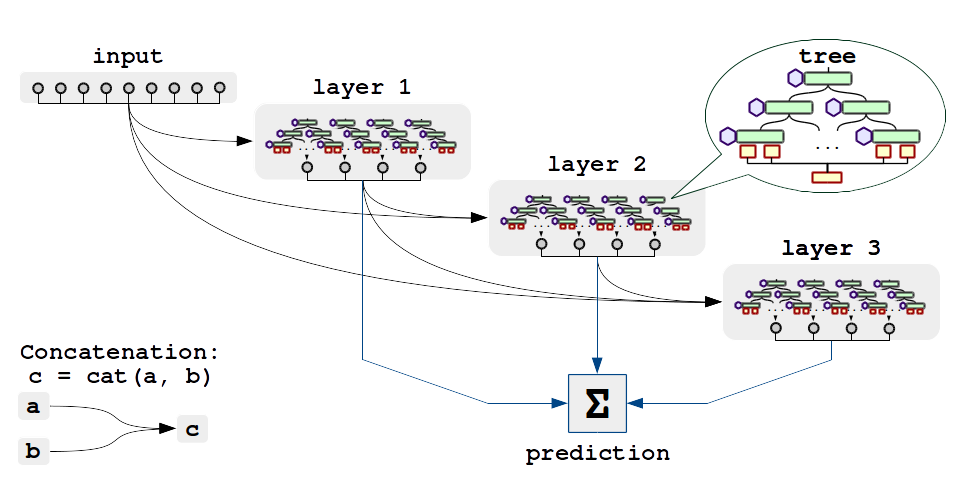

[1]: https://arxiv.org/pdf/1909.06312.pdf

In [2]:
import sys
# sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
import math, random
import gc, os
import datetime
import numpy as np
import pandas as pd
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration, AgglomerativeClustering, KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from hyperopt import hp, fmin, tpe, Trials
# from hyperopt.pyll.base import scope
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
train_features = pd.read_csv("../input/lish-moa/train_features.csv")
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [ ]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [ ]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(42)

In [ ]:
nfolds = 10
nstarts = 1
nepochs = 200
batch_size = 128
# batch_size = 1024
val_batch_size = batch_size * 4
ntargets = train_targets.shape[1]
targets = [col for col in train_targets.columns]
criterion = nn.BCELoss()

# for GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ODST/NODE

https://github.com/Qwicen/node

In [ ]:
import contextlib
from torch.autograd import Function
from collections import OrderedDict
from torch.jit import script
from warnings import warn
import os
import glob
import hashlib
import gc
import time
import requests

def to_one_hot(y, depth=None):
    r"""
    Takes integer with n dims and converts it to 1-hot representation with n + 1 dims.
    The n+1'st dimension will have zeros everywhere but at y'th index, where it will be equal to 1.
    Args:
        y: input integer (IntTensor, LongTensor or Variable) of any shape
        depth (int):  the size of the one hot dimension
    """
    y_flat = y.to(torch.int64).view(-1, 1)
    depth = depth if depth is not None else int(torch.max(y_flat)) + 1
    y_one_hot = torch.zeros(y_flat.size()[0], depth, device=y.device).scatter_(1, y_flat, 1)
    y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,)))
    return y_one_hot


def _make_ix_like(input, dim=0):
    d = input.size(dim)
    rho = torch.arange(1, d + 1, device=input.device, dtype=input.dtype)
    view = [1] * input.dim()
    view[0] = -1
    return rho.view(view).transpose(0, dim)


class SparsemaxFunction(Function):
    """
    An implementation of sparsemax (Martins & Astudillo, 2016). See
    :cite:`DBLP:journals/corr/MartinsA16` for detailed description.
    By Ben Peters and Vlad Niculae
    """

    @staticmethod
    def forward(ctx, input, dim=-1):
        """sparsemax: normalizing sparse transform (a la softmax)
        Parameters:
            input (Tensor): any shape
            dim: dimension along which to apply sparsemax
        Returns:
            output (Tensor): same shape as input
        """
        ctx.dim = dim
        max_val, _ = input.max(dim=dim, keepdim=True)
        input -= max_val  # same numerical stability trick as for softmax
        tau, supp_size = SparsemaxFunction._threshold_and_support(input, dim=dim)
        output = torch.clamp(input - tau, min=0)
        ctx.save_for_backward(supp_size, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        supp_size, output = ctx.saved_tensors
        dim = ctx.dim
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = grad_input.sum(dim=dim) / supp_size.to(output.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)
        grad_input = torch.where(output != 0, grad_input - v_hat, grad_input)
        return grad_input, None


    @staticmethod
    def _threshold_and_support(input, dim=-1):
        """Sparsemax building block: compute the threshold
        Args:
            input: any dimension
            dim: dimension along which to apply the sparsemax
        Returns:
            the threshold value
        """

        input_srt, _ = torch.sort(input, descending=True, dim=dim)
        input_cumsum = input_srt.cumsum(dim) - 1
        rhos = _make_ix_like(input, dim)
        support = rhos * input_srt > input_cumsum

        support_size = support.sum(dim=dim).unsqueeze(dim)
        tau = input_cumsum.gather(dim, support_size - 1)
        tau /= support_size.to(input.dtype)
        return tau, support_size


sparsemax = lambda input, dim=-1: SparsemaxFunction.apply(input, dim)
sparsemoid = lambda input: (0.5 * input + 0.5).clamp_(0, 1)


class Entmax15Function(Function):
    """
    An implementation of exact Entmax with alpha=1.5 (B. Peters, V. Niculae, A. Martins). See
    :cite:`https://arxiv.org/abs/1905.05702 for detailed description.
    Source: https://github.com/deep-spin/entmax
    """

    @staticmethod
    def forward(ctx, input, dim=-1):
        ctx.dim = dim

        max_val, _ = input.max(dim=dim, keepdim=True)
        input = input - max_val  # same numerical stability trick as for softmax
        input = input / 2  # divide by 2 to solve actual Entmax

        tau_star, _ = Entmax15Function._threshold_and_support(input, dim)
        output = torch.clamp(input - tau_star, min=0) ** 2
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        Y, = ctx.saved_tensors
        gppr = Y.sqrt()  # = 1 / g'' (Y)
        dX = grad_output * gppr
        q = dX.sum(ctx.dim) / gppr.sum(ctx.dim)
        q = q.unsqueeze(ctx.dim)
        dX -= q * gppr
        return dX, None

    @staticmethod
    def _threshold_and_support(input, dim=-1):
        Xsrt, _ = torch.sort(input, descending=True, dim=dim)

        rho = _make_ix_like(input, dim)
        mean = Xsrt.cumsum(dim) / rho
        mean_sq = (Xsrt ** 2).cumsum(dim) / rho
        ss = rho * (mean_sq - mean ** 2)
        delta = (1 - ss) / rho

        # NOTE this is not exactly the same as in reference algo
        # Fortunately it seems the clamped values never wrongly
        # get selected by tau <= sorted_z. Prove this!
        delta_nz = torch.clamp(delta, 0)
        tau = mean - torch.sqrt(delta_nz)

        support_size = (tau <= Xsrt).sum(dim).unsqueeze(dim)
        tau_star = tau.gather(dim, support_size - 1)
        return tau_star, support_size


class Entmoid15(Function):
    """ A highly optimized equivalent of labda x: Entmax15([x, 0]) """

    @staticmethod
    def forward(ctx, input):
        output = Entmoid15._forward(input)
        ctx.save_for_backward(output)
        return output

    @staticmethod
    @script
    def _forward(input):
        input, is_pos = abs(input), input >= 0
        tau = (input + torch.sqrt(F.relu(8 - input ** 2))) / 2
        tau.masked_fill_(tau <= input, 2.0)
        y_neg = 0.25 * F.relu(tau - input, inplace=True) ** 2
        return torch.where(is_pos, 1 - y_neg, y_neg)

    @staticmethod
    def backward(ctx, grad_output):
        return Entmoid15._backward(ctx.saved_tensors[0], grad_output)

    @staticmethod
    @script
    def _backward(output, grad_output):
        gppr0, gppr1 = output.sqrt(), (1 - output).sqrt()
        grad_input = grad_output * gppr0
        q = grad_input / (gppr0 + gppr1)
        grad_input -= q * gppr0
        return grad_input


entmax15 = lambda input, dim=-1: Entmax15Function.apply(input, dim)
entmoid15 = Entmoid15.apply


class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, *args, **kwargs):
        return self.func(*args, **kwargs)


class ModuleWithInit(nn.Module):
    """ Base class for pytorch module with data-aware initializer on first batch """
    def __init__(self):
        super().__init__()
        self._is_initialized_tensor = nn.Parameter(torch.tensor(0, dtype=torch.uint8), requires_grad=False)
        self._is_initialized_bool = None
        # Note: this module uses a separate flag self._is_initialized so as to achieve both
        # * persistence: is_initialized is saved alongside model in state_dict
        # * speed: model doesn't need to cache
        # please DO NOT use these flags in child modules

    def initialize(self, *args, **kwargs):
        """ initialize module tensors using first batch of data """
        raise NotImplementedError("Please implement ")

    def __call__(self, *args, **kwargs):
        if self._is_initialized_bool is None:
            self._is_initialized_bool = bool(self._is_initialized_tensor.item())
        if not self._is_initialized_bool:
            self.initialize(*args, **kwargs)
            self._is_initialized_tensor.data[...] = 1
            self._is_initialized_bool = True
        return super().__call__(*args, **kwargs)

def download(url, filename, delete_if_interrupted=True, chunk_size=4096):
    """ saves file from url to filename with a fancy progressbar """
    try:
        with open(filename, "wb") as f:
            print("Downloading {} > {}".format(url, filename))
            response = requests.get(url, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None:  # no content length header
                f.write(response.content)
            else:
                total_length = int(total_length)
                with tqdm(total=total_length) as progressbar:
                    for data in response.iter_content(chunk_size=chunk_size):
                        if data:  # filter-out keep-alive chunks
                            f.write(data)
                            progressbar.update(len(data))
    except Exception as e:
        if delete_if_interrupted:
            print("Removing incomplete download {}.".format(filename))
            os.remove(filename)
        raise e
    return filename


def iterate_minibatches(*tensors, batch_size, shuffle=True, epochs=1,
                        allow_incomplete=True, callback=lambda x:x):
    indices = np.arange(len(tensors[0]))
    upper_bound = int((np.ceil if allow_incomplete else np.floor) (len(indices) / batch_size)) * batch_size
    epoch = 0
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for batch_start in callback(range(0, upper_bound, batch_size)):
            batch_ix = indices[batch_start: batch_start + batch_size]
            batch = [tensor[batch_ix] for tensor in tensors]
            yield batch if len(tensors) > 1 else batch[0]
        epoch += 1
        if epoch >= epochs:
            break


def process_in_chunks(function, *args, batch_size, out=None, **kwargs):
    """
    Computes output by applying batch-parallel function to large data tensor in chunks
    :param function: a function(*[x[indices, ...] for x in args]) -> out[indices, ...]
    :param args: one or many tensors, each [num_instances, ...]
    :param batch_size: maximum chunk size processed in one go
    :param out: memory buffer for out, defaults to torch.zeros of appropriate size and type
    :returns: function(data), computed in a memory-efficient way
    """
    total_size = args[0].shape[0]
    first_output = function(*[x[0: batch_size] for x in args])
    output_shape = (total_size,) + tuple(first_output.shape[1:])
    if out is None:
        out = torch.zeros(*output_shape, dtype=first_output.dtype, device=first_output.device,
                          layout=first_output.layout, **kwargs)

    out[0: batch_size] = first_output
    for i in range(batch_size, total_size, batch_size):
        batch_ix = slice(i, min(i + batch_size, total_size))
        out[batch_ix] = function(*[x[batch_ix] for x in args])
    return out


def check_numpy(x):
    """ Makes sure x is a numpy array """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x)
    assert isinstance(x, np.ndarray)
    return x


@contextlib.contextmanager
def nop_ctx():
    yield None


def get_latest_file(pattern):
    list_of_files = glob.glob(pattern) # * means all if need specific format then *.csv
    assert len(list_of_files) > 0, "No files found: " + pattern
    return max(list_of_files, key=os.path.getctime)


def md5sum(fname):
    """ Computes mdp checksum of a file """
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()


def free_memory(sleep_time=0.1):
    """ Black magic function to free torch memory and some jupyter whims """
    gc.collect()
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(sleep_time)

def to_float_str(element):
    try:
        return str(float(element))
    except ValueError:
        return element
    
class ODST(ModuleWithInit):
    def __init__(self, in_features, num_trees, depth=6, tree_dim=1, flatten_output=True,
                 choice_function=sparsemax, bin_function=sparsemoid,
                 initialize_response_=nn.init.normal_, initialize_selection_logits_=nn.init.uniform_,
                 threshold_init_beta=1.0, threshold_init_cutoff=1.0,
                 ):
        """
        Oblivious Differentiable Sparsemax Trees. http://tinyurl.com/odst-readmore
        One can drop (sic!) this module anywhere instead of nn.Linear
        :param in_features: number of features in the input tensor
        :param num_trees: number of trees in this layer
        :param tree_dim: number of response channels in the response of individual tree
        :param depth: number of splits in every tree
        :param flatten_output: if False, returns [..., num_trees, tree_dim],
            by default returns [..., num_trees * tree_dim]
        :param choice_function: f(tensor, dim) -> R_simplex computes feature weights s.t. f(tensor, dim).sum(dim) == 1
        :param bin_function: f(tensor) -> R[0, 1], computes tree leaf weights
        :param initialize_response_: in-place initializer for tree output tensor
        :param initialize_selection_logits_: in-place initializer for logits that select features for the tree
        both thresholds and scales are initialized with data-aware init (or .load_state_dict)
        :param threshold_init_beta: initializes threshold to a q-th quantile of data points
            where q ~ Beta(:threshold_init_beta:, :threshold_init_beta:)
            If this param is set to 1, initial thresholds will have the same distribution as data points
            If greater than 1 (e.g. 10), thresholds will be closer to median data value
            If less than 1 (e.g. 0.1), thresholds will approach min/max data values.
        :param threshold_init_cutoff: threshold log-temperatures initializer, \in (0, inf)
            By default(1.0), log-remperatures are initialized in such a way that all bin selectors
            end up in the linear region of sparse-sigmoid. The temperatures are then scaled by this parameter.
            Setting this value > 1.0 will result in some margin between data points and sparse-sigmoid cutoff value
            Setting this value < 1.0 will cause (1 - value) part of data points to end up in flat sparse-sigmoid region
            For instance, threshold_init_cutoff = 0.9 will set 10% points equal to 0.0 or 1.0
            Setting this value > 1.0 will result in a margin between data points and sparse-sigmoid cutoff value
            All points will be between (0.5 - 0.5 / threshold_init_cutoff) and (0.5 + 0.5 / threshold_init_cutoff)
        """
        super().__init__()
        self.depth, self.num_trees, self.tree_dim, self.flatten_output = depth, num_trees, tree_dim, flatten_output
        self.choice_function, self.bin_function = choice_function, bin_function
        self.threshold_init_beta, self.threshold_init_cutoff = threshold_init_beta, threshold_init_cutoff

        self.response = nn.Parameter(torch.zeros([num_trees, tree_dim, 2 ** depth]), requires_grad=True)
        initialize_response_(self.response)

        self.feature_selection_logits = nn.Parameter(
            torch.zeros([in_features, num_trees, depth]), requires_grad=True
        )
        initialize_selection_logits_(self.feature_selection_logits)

        self.feature_thresholds = nn.Parameter(
            torch.full([num_trees, depth], float('nan'), dtype=torch.float32), requires_grad=True
        )  # nan values will be initialized on first batch (data-aware init)

        self.log_temperatures = nn.Parameter(
            torch.full([num_trees, depth], float('nan'), dtype=torch.float32), requires_grad=True
        )

        # binary codes for mapping between 1-hot vectors and bin indices
        with torch.no_grad():
            indices = torch.arange(2 ** self.depth)
            offsets = 2 ** torch.arange(self.depth)
            bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
            bin_codes_1hot = torch.stack([bin_codes, 1.0 - bin_codes], dim=-1)
            self.bin_codes_1hot = nn.Parameter(bin_codes_1hot, requires_grad=False)
            # ^-- [depth, 2 ** depth, 2]

    def forward(self, input):
        assert len(input.shape) >= 2
        if len(input.shape) > 2:
            return self.forward(input.view(-1, input.shape[-1])).view(*input.shape[:-1], -1)
        # new input shape: [batch_size, in_features]

        feature_logits = self.feature_selection_logits
        feature_selectors = self.choice_function(feature_logits, dim=0)
        # ^--[in_features, num_trees, depth]

        feature_values = torch.einsum('bi,ind->bnd', input, feature_selectors)
        # ^--[batch_size, num_trees, depth]

        threshold_logits = (feature_values - self.feature_thresholds) * torch.exp(-self.log_temperatures)

        threshold_logits = torch.stack([-threshold_logits, threshold_logits], dim=-1)
        # ^--[batch_size, num_trees, depth, 2]

        bins = self.bin_function(threshold_logits)
        # ^--[batch_size, num_trees, depth, 2], approximately binary

        bin_matches = torch.einsum('btds,dcs->btdc', bins, self.bin_codes_1hot)
        # ^--[batch_size, num_trees, depth, 2 ** depth]

        response_weights = torch.prod(bin_matches, dim=-2)
        # ^-- [batch_size, num_trees, 2 ** depth]

        response = torch.einsum('bnd,ncd->bnc', response_weights, self.response)
        # ^-- [batch_size, num_trees, tree_dim]

        return response.flatten(1, 2) if self.flatten_output else response

    def initialize(self, input, eps=1e-6):
        # data-aware initializer
        assert len(input.shape) == 2
        if input.shape[0] < 1000:
            warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
                 "To avoid potential problems, run this model on a data batch with at least 1000 data samples."
                 "You can do so manually before training. Use with torch.no_grad() for memory efficiency.")
        with torch.no_grad():
            feature_selectors = self.choice_function(self.feature_selection_logits, dim=0)
            # ^--[in_features, num_trees, depth]

            feature_values = torch.einsum('bi,ind->bnd', input, feature_selectors)
            # ^--[batch_size, num_trees, depth]

            # initialize thresholds: sample random percentiles of data
            percentiles_q = 100 * np.random.beta(self.threshold_init_beta, self.threshold_init_beta,
                                                 size=[self.num_trees, self.depth])
            self.feature_thresholds.data[...] = torch.as_tensor(
                list(map(np.percentile, check_numpy(feature_values.flatten(1, 2).t()), percentiles_q.flatten())),
                dtype=feature_values.dtype, device=feature_values.device
            ).view(self.num_trees, self.depth)

            # init temperatures: make sure enough data points are in the linear region of sparse-sigmoid
            temperatures = np.percentile(check_numpy(abs(feature_values - self.feature_thresholds)),
                                         q=100 * min(1.0, self.threshold_init_cutoff), axis=0)

            # if threshold_init_cutoff > 1, scale everything down by it
            temperatures /= max(1.0, self.threshold_init_cutoff)
            self.log_temperatures.data[...] = torch.log(torch.as_tensor(temperatures) + eps)

    def __repr__(self):
        return "{}(in_features={}, num_trees={}, depth={}, tree_dim={}, flatten_output={})".format(
            self.__class__.__name__, self.feature_selection_logits.shape[0],
            self.num_trees, self.depth, self.tree_dim, self.flatten_output
        )
    
class DenseBlock(nn.Sequential):
    def __init__(self, input_dim, layer_dim, num_layers, tree_dim=1, max_features=None,
                 input_dropout=0.0, flatten_output=True, Module=ODST, **kwargs):
        layers = []
        for i in range(num_layers):
            oddt = Module(input_dim, layer_dim, tree_dim=tree_dim, flatten_output=True, **kwargs)
            input_dim = min(input_dim + layer_dim * tree_dim, max_features or float('inf'))
            layers.append(oddt)

        super().__init__(*layers)
        self.num_layers, self.layer_dim, self.tree_dim = num_layers, layer_dim, tree_dim
        self.max_features, self.flatten_output = max_features, flatten_output
        self.input_dropout = input_dropout

    def forward(self, x):
        initial_features = x.shape[-1]
        for layer in self:
            layer_inp = x
            if self.max_features is not None:
                tail_features = min(self.max_features, layer_inp.shape[-1]) - initial_features
                if tail_features != 0:
                    layer_inp = torch.cat([layer_inp[..., :initial_features], layer_inp[..., -tail_features:]], dim=-1)
            if self.training and self.input_dropout:
                layer_inp = F.dropout(layer_inp, self.input_dropout)
            h = layer(layer_inp)
            x = torch.cat([x, h], dim=-1)

        outputs = x[..., initial_features:]
        if not self.flatten_output:
            outputs = outputs.view(*outputs.shape[:-1], self.num_layers * self.layer_dim, self.tree_dim)
        return outputs

# QHAdam

https://github.com/facebookresearch/qhoptim

In [ ]:
from torch.optim.optimizer import Optimizer, required
import collections
import math

QHMParams = collections.namedtuple("QHMParams", ["alpha", "nu", "beta"])

QHAdamParams = collections.namedtuple("QHAdamParams", ["alpha", "nu1", "nu2", "beta1", "beta2"])


def from_pid(k_p, k_i, k_d):
    alpha = k_i
    nu = k_p * k_p / (k_i * k_d)
    beta = k_d / (k_d - k_p)
    return QHMParams(alpha=alpha, nu=nu, beta=beta)


def from_synthesized_nesterov(alpha, beta1, beta2):
    new_alpha = alpha / (1.0 - beta1)
    nu = 1.0 - ((1.0 - beta1) / beta1) * beta2
    beta = beta1
    return QHMParams(alpha=new_alpha, nu=nu, beta=beta)


def from_robust_momentum(l, kappa, rho):
    if rho is None:
        rho = 1.0 - 1.0 / math.sqrt(kappa)

    alpha = kappa * ((1.0 - rho) ** 2) * (1.0 + rho) / l
    beta1 = kappa * (rho ** 3) / (kappa - 1.0)
    beta2 = (rho ** 3) / ((kappa - 1.0) * ((1.0 - rho) ** 2) * (1.0 + rho))
    return from_synthesized_nesterov(alpha, beta1, beta2)


def from_accsgd(delta, kappa, xi, eps):
    alpha = (delta * eps * (1.0 + xi)) / (1.0 + eps)
    nu = (eps * xi - 1.0) / (eps * (1.0 + xi))
    beta = (kappa - (eps * eps) * xi) / (kappa + eps * xi)
    return QHMParams(alpha=alpha, nu=nu, beta=beta)


def from_two_state_optimizer(h, k, l, m, q, z):
    phi = math.sqrt((h - q) * (h - q) + 4.0 * k * m)
    psi = k * m - h * q
    xi = (h - q - phi) * (l * m - h * z) + 2.0 * m * (l * q - k * z)

    alpha = 0.5 * xi / (phi * psi)
    nu = 2.0 * m * (l * q - k * z) / xi
    beta = 0.5 * (h + q - phi)
    return QHMParams(alpha=alpha, nu=nu, beta=beta)


def from_nadam(lr, beta1, beta2):
    return QHAdamParams(alpha=lr, nu1=beta1, nu2=1.0, beta1=beta1, beta2=beta2)

class QHM(Optimizer):
    r"""Implements the quasi-hyperbolic momentum (QHM) optimization algorithm
    `(Ma and Yarats, 2019)`_.
    Note that many other optimization algorithms are accessible via specific
    parameterizations of QHM. See :func:`from_accsgd()`,
    :func:`from_robust_momentum()`, etc. for details.
    Args:
        params (iterable):
            iterable of parameters to optimize or dicts defining parameter
            groups
        lr (float):
            learning rate (:math:`\alpha` from the paper)
        momentum (float):
            momentum factor (:math:`\beta` from the paper)
        nu (float):
            immediate discount factor (:math:`\nu` from the paper)
        weight_decay (float, optional):
            weight decay (L2 regularization coefficient, times two)
            (default: 0.0)
        weight_decay_type (str, optional):
            method of applying the weight decay:
            ``"grad"`` for accumulation in the gradient
            (same as :class:`torch.optim.SGD`) or
            ``"direct"`` for direct application to the parameters
            (default: ``"grad"``)
    Example:
        >>> optimizer = qhoptim.pyt.QHM(
        ...     model.parameters(), lr=1.0, nu=0.7, momentum=0.999)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    .. _`(Ma and Yarats, 2019)`: https://arxiv.org/abs/1810.06801
    .. note::
        Mathematically, QHM is a simple interpolation between plain SGD and
        momentum:
        .. math::
            \begin{align*}
                g_{t + 1} &\leftarrow
                    \beta \cdot g_t +
                    (1 - \beta) \cdot \nabla_t \\
                \theta_{t + 1} &\leftarrow
                    \theta_t + \alpha \left[ (1 - \nu) \cdot \nabla_t +
                                             \nu \cdot g_{t + 1} \right]
            \end{align*}
        Here, :math:`\alpha` is the learning rate, :math:`\beta` is the momentum
        factor, and :math:`\nu` is the "immediate discount" factor which
        controls the interpolation between plain SGD and momentum.
        :math:`g_t` is the momentum buffer, :math:`\theta_t` is the parameter
        vector, and :math:`\nabla_t` is the gradient with respect to
        :math:`\theta_t`.
    .. note::
        QHM uses **dampened** momentum. This means that when converting from
        plain momentum to QHM, the learning rate must be scaled by
        :math:`\frac{1}{1 - \beta}`. For example, momentum with learning rate
        :math:`\alpha = 0.1` and momentum :math:`\beta = 0.9` should be
        converted to QHM with learning rate :math:`\alpha = 1.0`.
    """

    def __init__(self, params, lr=required, momentum=required, nu=required, weight_decay=0.0, weight_decay_type="grad"):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if weight_decay_type not in ("grad", "direct"):
            raise ValueError("Invalid weight_decay_type value: {}".format(weight_decay_type))

        defaults = {
            "lr": lr,
            "momentum": momentum,
            "nu": nu,
            "weight_decay": weight_decay,
            "weight_decay_type": weight_decay_type,
        }
        super(QHM, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional):
                A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr, nu, momentum = group["lr"], group["nu"], group["momentum"]
            weight_decay, weight_decay_type = group["weight_decay"], group["weight_decay_type"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]

                if weight_decay != 0:
                    if weight_decay_type == "grad":
                        d_p.add_(weight_decay, p.data)
                    elif weight_decay_type == "direct":
                        p.data.mul_(1.0 - lr * weight_decay)
                    else:
                        raise ValueError("Invalid weight decay type provided")

                if len(param_state) == 0:
                    param_state["momentum_buffer"] = torch.zeros_like(p.data)

                momentum_buffer = param_state["momentum_buffer"]
                momentum_buffer.mul_(momentum).add_(1.0 - momentum, d_p)

                p.data.add_(-lr * nu, momentum_buffer)
                p.data.add_(-lr * (1.0 - nu), d_p)

        return loss

    @classmethod
    def _params_to_dict(cls, params):
        return {"lr": params.alpha, "nu": params.nu, "momentum": params.beta}

    @classmethod
    def from_pid(cls, k_p, k_i, k_d):
        r"""Calculates the QHM hyperparameters required to recover a PID
        optimizer as described in `Recht (2018)`_.
        Args:
            k_p (float):
                proportional gain (see reference)
            k_i (float):
                integral gain (see reference)
            k_d (float):
                derivative gain (see reference)
        Returns:
            Three-element ``dict`` containing ``lr``, ``momentum``, and ``nu``
            to use in QHM.
        Example:
            >>> optimizer = qhoptim.pyt.QHM(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHM.from_pid(
            ...         k_p=-0.1, k_i=1.0, k_d=3.0))
        .. _`Recht (2018)`: https://web.archive.org/web/20181027184056/http://www.argmin.net/2018/04/19/pid/
        """
        return cls._params_to_dict(param_conv.from_pid(k_p, k_i, k_d))

    @classmethod
    def from_synthesized_nesterov(cls, alpha, beta1, beta2):
        r"""Calculates the QHM hyperparameters required to recover the
        synthesized Nesterov optimizer (Section 6 of `Lessard et al. (2016)`_).
        Args:
            alpha (float):
                learning rate
            beta1 (float):
                first momentum (see reference)
            beta2 (float):
                second momentum (see reference)
        Returns:
            Three-element ``dict`` containing ``lr``, ``momentum``, and ``nu``
            to use in QHM.
        Example:
            >>> optimizer = qhoptim.pyt.QHM(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHM.from_synthesized_nesterov(
            ...         alpha=0.1, beta1=0.9, beta2=0.6))
        .. _`Lessard et al. (2016)`: https://arxiv.org/abs/1408.3595
        """
        return cls._params_to_dict(param_conv.from_synthesized_nesterov(alpha, beta1, beta2))

    @classmethod
    def from_robust_momentum(cls, l, kappa, rho=None):
        r"""Calculates the QHM hyperparameters required to recover the Robust
        Momentum `(Cyrus et al., 2018)`_ or Triple Momentum
        `(Scoy et al., 2018)`_ optimizers.
        Args:
            l (float):
                Lipschitz constant of gradient (see reference)
            kappa (float):
                condition ratio (see reference)
            rho (float, optional):
                noise-free convergence rate. If None, will return the
                parameters for the Triple Momentum optimizer.
        Returns:
            Three-element ``dict`` containing ``lr``, ``momentum``, and ``nu``
            to use in QHM.
        Example:
            >>> optimizer = qhoptim.pyt.QHM(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHM.from_robust_momentum(
            ...         l=5.0, kappa=15.0))
        .. _`(Cyrus et al., 2018)`: https://arxiv.org/abs/1710.04753
        .. _`(Scoy et al., 2018)`: http://www.optimization-online.org/DB_FILE/2017/03/5908.pdf
        """
        return cls._params_to_dict(param_conv.from_robust_momentum(l, kappa, rho))

    @classmethod
    def from_accsgd(cls, delta, kappa, xi, eps=0.7):
        r"""Calculates the QHM hyperparameters required to recover the AccSGD
        optimizer `(Kidambi et al., 2018)`_.
        Args:
            delta (float):
                short step (see reference)
            kappa (float):
                long step parameter (see reference)
            xi (float):
                statistical advantage parameter (see reference)
            eps (float, optional):
                arbitrary value, between 0 and 1 exclusive (see reference)
                (default: 0.7)
        Returns:
            Three-element ``dict`` containing ``lr``, ``momentum``, and ``nu``
            to use in QHM.
        Example:
            >>> optimizer = qhoptim.pyt.QHM(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHM.from_accsgd(
            ...         delta=0.1, kappa=1000.0, xi=10.0))
        .. _`(Kidambi et al., 2018)`: https://arxiv.org/abs/1803.05591
        """
        return cls._params_to_dict(param_conv.from_accsgd(delta, kappa, xi, eps))

    @classmethod
    def from_two_state_optimizer(cls, h, k, l, m, q, z):
        r"""Calculates the QHM hyperparameters required to recover the
        following optimizer (named "TSO" in `Ma and Yarats (2019)`_):
        .. math::
            \begin{align*}
                a_{t + 1} &\leftarrow
                    h \cdot a_t + k \cdot \theta_t + l \cdot \nabla_t \\
                \theta_{t + 1} &\leftarrow
                    m \cdot a_t + q \cdot \theta_t + z \cdot \nabla_t
            \end{align*}
        Here, :math:`a_t` and :math:`\theta_t` are the two states and
        :math:`\nabla_t` is the gradient with respect to :math:`\theta_t`.
        Be careful that your coefficients satisfy the regularity conditions
        from the reference.
        Args:
            h (float):
                see description
            k (float):
                see description
            l (float):
                see description
            m (float):
                see description
            q (float):
                see description
            z (float):
                see description
        Returns:
            Three-element ``dict`` containing ``lr``, ``momentum``, and ``nu``
            to use in QHM.
        Example:
            >>> optimizer = qhoptim.pyt.QHM(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHM.from_two_state_optimizer(
            ...         h=0.9, k=0.0, l=0.1, m=-0.09, q=1.0, z=-0.01))
        .. _`Ma and Yarats (2019)`: https://arxiv.org/abs/1810.06801
        """
        return cls._params_to_dict(param_conv.from_two_state_optimizer(h, k, l, m, q, z))

class QHAdam(Optimizer):
    r"""Implements the QHAdam optimization algorithm `(Ma and Yarats, 2019)`_.
    Note that the NAdam optimizer is accessible via a specific parameterization
    of QHAdam. See :func:`from_nadam()` for details.
    Args:
        params (iterable):
            iterable of parameters to optimize or dicts defining parameter
            groups
        lr (float, optional): learning rate (:math:`\alpha` from the paper)
            (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of the gradient and its square
            (default: (0.9, 0.999))
        nus (Tuple[float, float], optional): immediate discount factors used to
            estimate the gradient and its square
            (default: (1.0, 1.0))
        eps (float, optional): term added to the denominator to improve
            numerical stability
            (default: 1e-8)
        weight_decay (float, optional): weight decay (default: 0.0)
        decouple_weight_decay (bool, optional): whether to decouple the weight
            decay from the gradient-based optimization step
            (default: False)
    Example:
        >>> optimizer = qhoptim.pyt.QHAdam(
        ...     model.parameters(),
        ...     lr=3e-4, nus=(0.8, 1.0), betas=(0.99, 0.999))
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    .. _`(Ma and Yarats, 2019)`: https://arxiv.org/abs/1810.06801
    """

    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        nus=(1.0, 1.0),
        weight_decay=0.0,
        decouple_weight_decay=False,
        eps=1e-8,
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = {
            "lr": lr,
            "betas": betas,
            "nus": nus,
            "weight_decay": weight_decay,
            "decouple_weight_decay": decouple_weight_decay,
            "eps": eps,
        }
        super(QHAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional):
                A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["betas"]
            nu1, nu2 = group["nus"]
            weight_decay = group["weight_decay"]
            decouple_weight_decay = group["decouple_weight_decay"]
            eps = group["eps"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                d_p = p.grad.data
                if d_p.is_sparse:
                    raise RuntimeError("QHAdam does not support sparse gradients")

                param_state = self.state[p]

                if weight_decay != 0:
                    if decouple_weight_decay:
                        p.data.mul_(1 - lr * weight_decay)
                    else:
                        d_p.add_(weight_decay, p.data)

                d_p_sq = d_p.mul(d_p)

                if len(param_state) == 0:
                    param_state["beta1_weight"] = 0.0
                    param_state["beta2_weight"] = 0.0
                    param_state["exp_avg"] = torch.zeros_like(p.data)
                    param_state["exp_avg_sq"] = torch.zeros_like(p.data)

                param_state["beta1_weight"] = 1.0 + beta1 * param_state["beta1_weight"]
                param_state["beta2_weight"] = 1.0 + beta2 * param_state["beta2_weight"]

                beta1_weight = param_state["beta1_weight"]
                beta2_weight = param_state["beta2_weight"]
                exp_avg = param_state["exp_avg"]
                exp_avg_sq = param_state["exp_avg_sq"]

                beta1_adj = 1.0 - (1.0 / beta1_weight)
                beta2_adj = 1.0 - (1.0 / beta2_weight)
                exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)
                exp_avg_sq.mul_(beta2_adj).add_(1.0 - beta2_adj, d_p_sq)

                avg_grad = exp_avg.mul(nu1)
                if nu1 != 1.0:
                    avg_grad.add_(1.0 - nu1, d_p)

                avg_grad_rms = exp_avg_sq.mul(nu2)
                if nu2 != 1.0:
                    avg_grad_rms.add_(1.0 - nu2, d_p_sq)
                avg_grad_rms.sqrt_()
                if eps != 0.0:
                    avg_grad_rms.add_(eps)

                p.data.addcdiv_(-lr, avg_grad, avg_grad_rms)

        return loss

    @classmethod
    def _params_to_dict(cls, params):
        return {"lr": params.alpha, "nus": (params.nu1, params.nu2), "betas": (params.beta1, params.beta2)}

    @classmethod
    def from_nadam(cls, lr=1e-3, betas=(0.9, 0.999)):
        r"""Calculates the QHAdam hyperparameters required to recover the NAdam
        optimizer `(Dozat, 2016)`_.
        This is *not* an identical recovery of the formulation in the paper, due
        to subtle differences in the application of the bias correction in the
        first moment estimator. However, in practice, this difference is almost
        certainly irrelevant.
        Args:
            lr (float, optional):
                learning rate (:math:`\alpha` from the paper)
                (default: 1e-3)
            betas (Tuple[float, float], optional):
                coefficients used for computing running averages of the
                gradient and its square
                (default: (0.9, 0.999))
        Returns:
            Three-element ``dict`` containing ``lr``, ``betas``, and ``nus``
            to use in QHAdam.
        Example:
            >>> optimizer = qhoptim.pyt.QHAdam(
            ...     model.parameters(),
            ...     weight_decay=1e-4,
            ...     **qhoptim.pyt.QHAdam.from_nadam(
            ...         lr=1e-3, betas=(0.9, 0.999)))
        .. _`(Dozat, 2016)`: https://openreview.net/pdf?id=OM0jvwB8jIp57ZJjtNEZ
        """
        return cls._params_to_dict(param_conv.from_nadam(lr, betas[0], betas[1]))


def QHAdamW(params, *args, **kwargs):
    r"""Constructs the decoupled decay variant of the QHAdam optimization
    algorithm `(Ma and Yarats, 2019)`_,
    as proposed by `Loschilov and Hutter (2017)`_.
    Shares all arguments of the :class:`QHAdam` constructor –
    equivalent to constructing :class:`QHAdam` with
    ``decouple_weight_decay=True``.
    .. _`Loschilov and Hutter (2017)`: https://arxiv.org/abs/1711.05101
    .. _`(Ma and Yarats, 2019)`: https://arxiv.org/abs/1810.06801
    """
    return QHAdam(params, *args, decouple_weight_decay=True, **kwargs)

# Features

In [ ]:
top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

print(len(top_feats))

In [ ]:
# dataset class
class MoaDataset(Dataset):
    def __init__(self, df, targets, feats_idx, mode='train'):
        self.mode = mode
        self.feats = feats_idx
        self.data = df[:, feats_idx]
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'test':
            return torch.FloatTensor(self.data[idx]), 0

In [ ]:
train = train.values
test = test.values
train_targets = train_targets.values

# Training

The model I use here is different from the one suggested in the paper. Here, I flatten all the outputs of the trees and pass a final dense layer. I found this approach can accelerate the convergence and generate better results.

P.S. Using more trees significantly increases the training time but no obvious improvement on CV and LB.

In [ ]:
for seed in range(nstarts):
    
    kfold = MultilabelStratifiedKFold(n_splits=nfolds, random_state=seed, shuffle=True)
    for n, (tr, te) in enumerate(kfold.split(train_targets, train_targets)):
        start_time = time.time()
        xtrain, xval = train[tr], train[te]
        ytrain, yval = train_targets[tr], train_targets[te]

        train_set = MoaDataset(xtrain, ytrain, top_feats)
        val_set = MoaDataset(xval, yval, top_feats)

        dataloaders = {
            'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_set, batch_size=val_batch_size, shuffle=False)
        }

        model = nn.Sequential(nn.BatchNorm1d(len(top_feats)), 
                              DenseBlock(len(top_feats), layer_dim = 16, num_layers = 4, tree_dim = 512, depth = 6, input_dropout = 0.3,
                                         flatten_output = True, choice_function = entmax15, bin_function = entmoid15), 
                              nn.BatchNorm1d(16 * 4 * 512), 
                              nn.Dropout(0.5), 
                              nn.utils.weight_norm(nn.Linear(16 * 4 * 512, 206)), 
                              nn.Sigmoid(), 
                             ).to(device)
        checkpoint_path = f'Model_{seed}_Fold_{n+1}.pt'
        optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
#         optimizer = QHAdam(model.parameters(), lr = 1e-3, nus = (0.7, 1.0), betas = (0.95, 0.998), weight_decay = 1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, 
                                                         patience = 10, eps = 1e-4, verbose = False)
        best_loss = {'train': np.inf, 'val': np.inf}
        
        es_count = 0
        for epoch in range(nepochs):
            epoch_loss = {'train': 0.0, 'val': 0.0}

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0

                for i, (x, y) in enumerate(dataloaders[phase]):
                    x, y = x.to(device), y.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase=='train'):
                        preds = model(x)
                        loss = criterion(preds, y)

                        if phase=='train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() / len(dataloaders[phase])

                epoch_loss[phase] = running_loss

            scheduler.step(epoch_loss['val'])

            if epoch_loss['val'] < best_loss['val']:
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)
                es_count = 0
            else:
                es_count += 1
                
#             print("Epoch {}/{} - loss: {:5.5f} - val_loss: {:5.5f} - es: {}".format(epoch+1, nepochs, epoch_loss['train'], epoch_loss['val'], es_count))
            
            if es_count > 20:
                break
        
        print("[{}] - seed: {} - fold: {} - best val_loss: {:5.5f}".format(str(datetime.timedelta(seconds = time.time() - start_time))[2:7], seed, n, best_loss['val']))

In [ ]:
oof = np.zeros((len(train), nstarts, ntargets))
oof_targets = np.zeros((len(train), ntargets))
preds = np.zeros((len(test), ntargets))

In [ ]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(targets):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

# Inference

In [ ]:
for seed in range(nstarts):
    print(f"Inference for seed {seed}")
    seed_targets = []
    seed_oof = []
    seed_preds = np.zeros((len(test), ntargets, nfolds))
    
    for n, (tr, te) in enumerate(kfold.split(train_targets, train_targets)):
        xval, yval = train[te], train_targets[te]
        fold_preds = []
        
        val_set = MoaDataset(xval, yval, top_feats)
        test_set = MoaDataset(test, None, top_feats, mode='test')
        
        dataloaders = {
            'val': DataLoader(val_set, batch_size=val_batch_size, shuffle=False),
            'test': DataLoader(test_set, batch_size=val_batch_size, shuffle=False)
        }
        
        checkpoint_path = f'Model_{seed}_Fold_{n+1}.pt'
        model = nn.Sequential(nn.BatchNorm1d(len(top_feats)), 
                              DenseBlock(len(top_feats), layer_dim = 16, num_layers = 4, tree_dim = 512, depth = 6, input_dropout = 0.3,
                                         flatten_output = True, choice_function = entmax15, bin_function = entmoid15), 
                              nn.BatchNorm1d(16 * 4 * 512), 
                              nn.Dropout(0.5), 
                              nn.utils.weight_norm(nn.Linear(16 * 4 * 512, 206)), 
                              nn.Sigmoid(), 
                             ).to(device)
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()
        
        for phase in ['val', 'test']:
            for i, (x, y) in enumerate(dataloaders[phase]):
                if phase == 'val':
                    x, y = x.to(device), y.to(device)
                elif phase == 'test':
                    x = x.to(device)
                
                with torch.no_grad():
                    batch_preds = model(x)
                    
                    if phase == 'val':
                        seed_targets.append(y)
                        seed_oof.append(batch_preds)
                    elif phase == 'test':
                        fold_preds.append(batch_preds)
                    
        fold_preds = torch.cat(fold_preds, dim=0).cpu().numpy()
        seed_preds[:, :, n] = fold_preds
        
    seed_targets = torch.cat(seed_targets, dim=0).cpu().numpy()
    seed_oof = torch.cat(seed_oof, dim=0).cpu().numpy()
    seed_preds = np.mean(seed_preds, axis=2)
    
    print("Score for this seed {:5.5f}".format(mean_log_loss(seed_targets, seed_oof)))
    oof_targets = seed_targets
    oof[:, seed, :] = seed_oof
    preds += seed_preds / nstarts

In [ ]:
oof = np.mean(oof, axis=1)
print("Overall score is {:5.5f}".format(mean_log_loss(oof_targets, oof)))

In [ ]:
ss[targets] = preds
ss.loc[test_features['cp_type']=='ctl_vehicle', targets] = 0
ss.to_csv('submission.csv', index=False)